# Objetivo

## Reduzir churn

A empresa de telecomunicações contratou a A3Data para avaliar o cenário de
churn elevado dos seus clientes e, uma vez que estamos falando de um produto
com custo elevado de setup (instalação), a empresa gostaria de uma estratégia
para reduzir esse churn.

# Imports iniciais

In [1]:
import pandas as pd
import numpy as np
from typing import Dict, Any, List

from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV

from sklearn.metrics import (
    RocCurveDisplay,
    classification_report,
    roc_auc_score,
    confusion_matrix,
)

In [2]:
RANDOM_STATE = 42
TEST_SIZE = 0.25
N_SPLITS = 5
TOP_K_IMPORTANCES = 15
RF_N_EST = 1000
XGB_N_EST = 1000

In [3]:
churn = pd.read_csv("data/customer_churn_verified.csv")

In [4]:
churn.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_bucket,charge_quantile,addon_count,ChurnFlag,high_value_customer
0,7569-NMZYQ,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,Yes,...,Yes,Bank transfer (automatic),118.75,8672.45,No,61m+,Q4,6,0,1
1,8984-HPEMB,Female,0,No,No,71,Yes,Yes,Fiber optic,Yes,...,Yes,Electronic check,118.65,8477.60,No,61m+,Q4,6,0,1
2,5989-AXPUC,Female,0,Yes,No,68,Yes,Yes,Fiber optic,Yes,...,No,Mailed check,118.60,7990.05,No,61m+,Q4,6,0,1
3,5734-EJKXG,Female,0,No,No,61,Yes,Yes,Fiber optic,Yes,...,Yes,Electronic check,118.60,7365.70,No,61m+,Q4,6,0,1
4,8199-ZLLSA,Male,0,No,No,67,Yes,Yes,Fiber optic,Yes,...,Yes,Bank transfer (automatic),118.35,7804.15,Yes,61m+,Q4,6,1,1


# Preparação

In [5]:
num_cols = ["tenure", "MonthlyCharges", "TotalCharges", "addon_count"]
cat_cols = [
    c
    for c in churn.columns
    if c not in num_cols + ["customerID", "Churn", "ChurnFlag"]
    and churn[c].dtype == "object"
]

In [6]:
churn["ChurnFlag"] = churn["Churn"].map({"No": 0, "Yes": 1})

In [7]:
cat_cols += ["SeniorCitizen", "high_value_customer"]

In [8]:
X = churn[num_cols + cat_cols]
y = churn["ChurnFlag"]

In [9]:
random_number = 42

In [10]:
def build_preprocessor(num_cols: List[str], cat_cols: List[str]) -> ColumnTransformer:
    """ColumnTransformer: imputação + escala (num)  e imputa + OHE (cat)."""

    numeric_pipe = Pipeline(
        [
            ("impute", SimpleImputer(strategy="median")),
            ("scale", StandardScaler()),
        ]
    )

    categorical_pipe = Pipeline(
        [
            ("impute", SimpleImputer(strategy="most_frequent")),
            ("encode", OneHotEncoder(handle_unknown="ignore")),
        ]
    )

    preprocess = ColumnTransformer(
        [
            ("num", numeric_pipe, num_cols),
            ("cat", categorical_pipe, cat_cols),
        ]
    )

    return preprocess

In [11]:
def build_selector() -> RFECV:
    """
    RFECV usando Regressão Logística L2 como estimador base.
    Seleção guiada por AUC, avaliada em k-fold estratificado.
    """
    base_estimator = LogisticRegression(
        solver="liblinear",
        penalty="l2",
        class_weight="balanced",
        max_iter=3000,
        random_state=RANDOM_STATE,
    )
    return RFECV(
        estimator=base_estimator,
        step=1,
        cv=StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE),
        scoring="roc_auc",
        min_features_to_select=10,
        n_jobs=-1,
    )

# Modelagem

In [12]:
def train_model(
    name: str,
    estimator,
    preprocessor: ColumnTransformer,
    selector: RFECV,
    X_train: pd.DataFrame,
    X_test: pd.DataFrame,
    y_train: pd.Series,
    y_test: pd.Series,
) -> Dict[str, Any]:
    """
    Treina <estimator> dentro de um Pipeline, avalia no hold-out
    e retorna métricas + importância de variáveis (quando disponível).

    Parameters
    ----------
    name : str
        Rótulo para o modelo (ex.: 'RandomForest').
    estimator : scikit-learn estimator
        Algoritmo de classificação já instanciado.
    preprocess : ColumnTransformer
        Transformações numéricas/categóricas.
    X_train, X_test, y_train, y_test
        Conjuntos de dados estratificados.
    num_cols, cat_cols : list[str]
        Listas originais de colunas numéricas e categóricas.

    Returns
    -------
    dict
        Contém métricas, previsões, nomes de features expandidas
        e DataFrame `importance_df` ordenado (ou None).
    """

    pipe = Pipeline([("prep", preprocessor), ("select", selector), ("clf", estimator)])

    pipe.fit(X_train, y_train)
    proba = pipe.predict_proba(X_test)[:, 1]
    pred = pipe.predict(X_test)

    print(f"\n===== {name} =====")
    print(classification_report(y_test, pred, digits=3))
    print(f"AUC: {roc_auc_score(y_test, proba):.3f}")

    auc = roc_auc_score(y_test, proba)
    cm = confusion_matrix(y_test, pred)
    report = classification_report(y_test, pred, digits=3, output_dict=True)

    RocCurveDisplay.from_predictions(y_test, proba).plot()

    encoder = pipe.named_steps["prep"].named_transformers_["cat"].named_steps["encode"]

    cat_feats = encoder.get_feature_names_out(cat_cols).tolist()
    numeric_feats = num_cols
    feat_names = numeric_feats + cat_feats

    mask = pipe.named_steps["select"].support_
    selected_feats = np.array(feat_names)[mask]

    if hasattr(estimator, "feature_importances_"):

        importances = estimator.feature_importances_
        importance_df = pd.DataFrame(
            {"feature": selected_feats, "importance": importances}
        ).sort_values("importance", ascending=False)

    elif hasattr(estimator, "coef_"):
        importances = np.abs(estimator.coef_).ravel()

        importance_df = (
            pd.DataFrame({"feature": selected_feats, "importance": importances})
            .sort_values("importance", ascending=False)
            .reset_index(drop=True)
        )

    return {
        "name": name,
        "model": pipe,
        "auc": auc,
        "cm": cm,
        "report": report,
        "feature_names": selected_feats,
        "importances": importances,
        "importance_df": importance_df,
        "pred": pred,
        "proba": proba,
    }

In [13]:
preprocessor = build_preprocessor(num_cols, cat_cols)
selector = build_selector()

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
)

In [15]:
rl_estimator = LogisticRegression(
    max_iter=3000, class_weight="balanced", solver="liblinear"
)


===== LogisticRegression =====
              precision    recall  f1-score   support

           0      0.911     0.715     0.801      1293
           1      0.506     0.808     0.622       468

    accuracy                          0.739      1761
   macro avg      0.709     0.761     0.712      1761
weighted avg      0.804     0.739     0.754      1761

AUC: 0.841


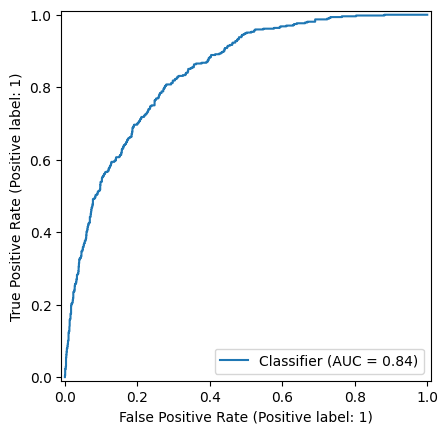

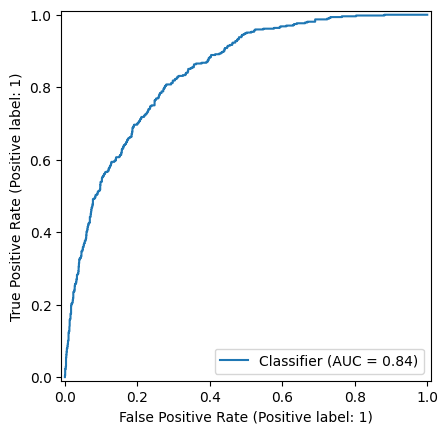

In [16]:
rl_trained = train_model(
    "LogisticRegression",
    rl_estimator,
    preprocessor,
    selector,
    X_train,
    X_test,
    y_train,
    y_test,
)

In [17]:
rl_trained["importance_df"]

,feature,importance
0,Contract_Two year,0.804904
1,Contract_Month-to-month,0.765053
2,tenure,0.761539
3,tenure_bucket_≤6m,0.673630
4,InternetService_DSL,0.440276
5,InternetService_Fiber optic,0.424796
6,PaperlessBilling_No,0.360300
7,PaymentMethod_Electronic check,0.304704
8,MultipleLines_No,0.302681
9,high_value_customer_0,0.302432


In [18]:
rf_estimator = RandomForestClassifier(
    n_estimators=RF_N_EST,
    class_weight="balanced",
    random_state=RANDOM_STATE,
    n_jobs=-1,
)


===== RandomForest =====
              precision    recall  f1-score   support

           0      0.819     0.873     0.845      1293
           1      0.571     0.466     0.513       468

    accuracy                          0.765      1761
   macro avg      0.695     0.669     0.679      1761
weighted avg      0.753     0.765     0.757      1761

AUC: 0.806


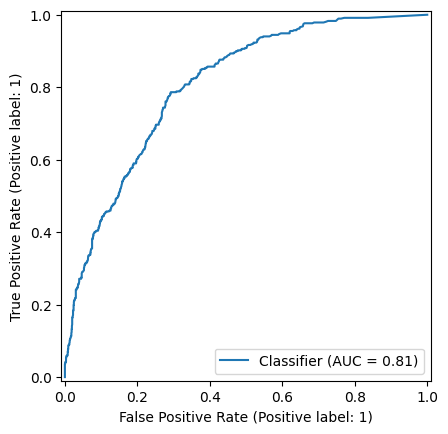

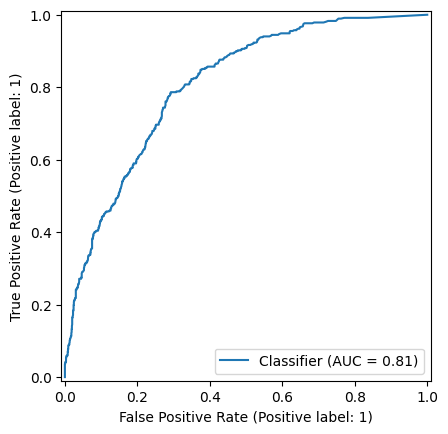

In [19]:
rf_trained = train_model(
    "RandomForest",
    rf_estimator,
    preprocessor,
    selector,
    X_train,
    X_test,
    y_train,
    y_test,
)

In [20]:
rf_trained["importance_df"].shape

(29, 2)

In [21]:
rf_trained["importance_df"]

,feature,importance
1,TotalCharges,0.261863
0,tenure,0.173733
19,Contract_Month-to-month,0.088249
6,OnlineSecurity_No,0.044061
20,Contract_Two year,0.041610
11,TechSupport_No,0.041597
22,PaymentMethod_Electronic check,0.037179
5,InternetService_Fiber optic,0.032112
8,OnlineBackup_No,0.031128
21,PaperlessBilling_No,0.029606


Reduziu o número de variáveis utilizadas no modelo com RFECV. Com TotalCharges, tenure e Contrato ainda sendo as mais importantes.

In [22]:
xgb_estimator = XGBClassifier(
    n_estimators=XGB_N_EST,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=(y == 0).sum() / (y == 1).sum(),
    eval_metric="logloss",
    random_state=RANDOM_STATE,
    n_jobs=-1,
)


===== XGBoost =====
              precision    recall  f1-score   support

           0      0.858     0.776     0.815      1293
           1      0.510     0.645     0.570       468

    accuracy                          0.741      1761
   macro avg      0.684     0.711     0.692      1761
weighted avg      0.766     0.741     0.750      1761

AUC: 0.805


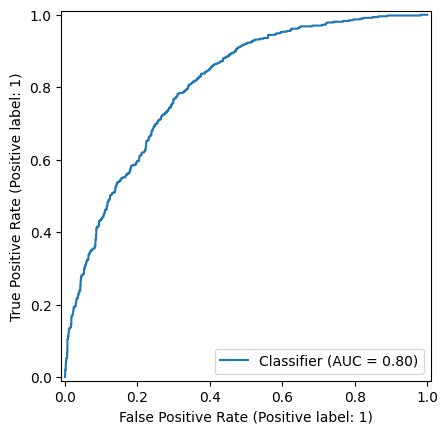

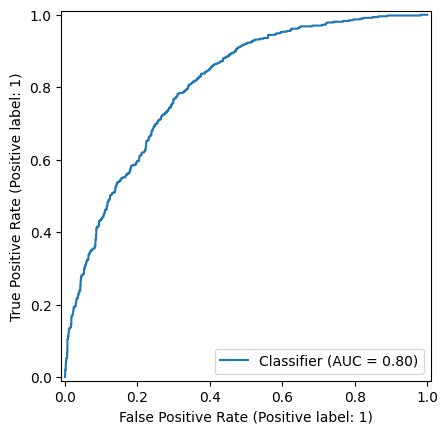

In [23]:
xgb_trained = train_model(
    "XGBoost",
    xgb_estimator,
    preprocessor,
    selector,
    X_train,
    X_test,
    y_train,
    y_test,
)

In [24]:
xgb_trained["importance_df"].shape

(29, 2)

In [27]:
summary_rows = []
models_info = [rl_trained, rf_trained, xgb_trained]
for m in models_info:
    prec = m["report"]["weighted avg"]["precision"]
    rec = m["report"]["weighted avg"]["recall"]
    f1 = m["report"]["weighted avg"]["f1-score"]
    summary_rows.append(
        {
            "Model": m["name"],
            "AUC": round(m["auc"], 3),
            "Precision": round(prec, 3),
            "Recall": round(rec, 3),
            "F1": round(f1, 3),
        }
    )
summary_churn = pd.DataFrame(summary_rows)

In [28]:
summary_churn

,Model,AUC,Precision,Recall,F1
0,LogisticRegression,0.841,0.804,0.739,0.754
1,RandomForest,0.806,0.753,0.765,0.757
2,XGBoost,0.805,0.766,0.741,0.750


Random Forest ainda é o modelo com melhor F1.